# Modeling

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
df = pd.read_csv(r"EHIS_2019_IT\MICRODATI\EHIS_Microdati_2019.txt", sep='\t', encoding='utf-8')
df_finale = pd.read_csv(r"EHIS_2019_IT/MICRODATI/EHIS_2019_IT_finale.csv", sep=',', encoding='utf-8')

KeyboardInterrupt: 

In [ ]:
df_finale["UN2A"] = df["UN2A"]

In [ ]:
proxy_indices = df[df.eq(-3).any(axis=1)].index

# Salva gli indici in una lista (opzionale, se vuoi una lista pura)
proxy_indices_list = proxy_indices.tolist()

proxy_count = (df.eq(-3).any(axis=1)).sum()
print(proxy_count)

2488


In [ ]:
# Rimozione delle righe corrispondenti a indici con -3 (PROXY)
df_finale_clean = df_finale.drop(index=proxy_indices)

In [ ]:
df_finale_clean['PROXY'].value_counts()
2488 + 4476
# out of 6579

6964

In [ ]:
proxy_indices_un2a = df[df["UN2A"] == -3].index
# Rimuovi quelle righe da df_finale
df_finale_model = df_finale.drop(index=proxy_indices_un2a)
df_finale_model["UN2A"].value_counts()

UN2A
2    24812
3    17850
1     2281
Name: count, dtype: int64

In [ ]:
print(df_finale_model.columns[df_finale_model.isnull().any()].tolist())

['dolore_intensita', 'dolore_interferenza', 'MH1A_ord', 'MH1B_ord', 'MH1C_ord', 'MH1D_ord', 'MH1E_ord', 'MH1F_ord', 'MH1G_ord', 'MH1H_ord', 'ho12_notti_ospedale']


In [ ]:
# le righe che hanno i nans sono i proxy (value = -3)

le righe che hanno i nans sono i proxy (value = -3). Li vediamo qui dall'output R

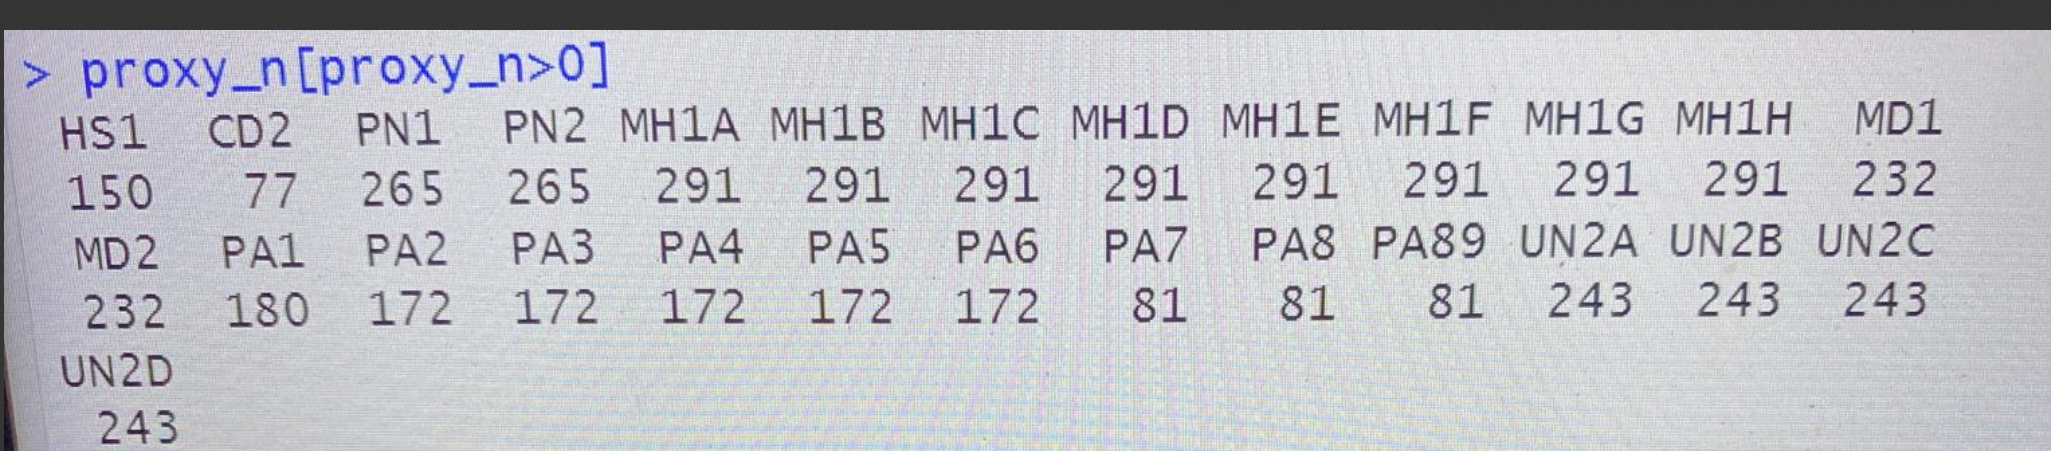

In [ ]:
from sklearn.model_selection import train_test_split

df_finale_model = df_finale_model.dropna()

X = df_finale_model.drop(columns=["UN2A"])
y = df_finale_model["UN2A"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### L1 Regularization (Lasso)
Fit a logistic regression with penalty='l1'. L1 regularization forces some coefficients to zero, effectively selecting features.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

# 1. Scala le feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Scegli manualmente il valore di C (regolarizzazione)
C = 0.01  # Cambia il valore qui per rendere la selezione più o meno aggressiva

# 3. Fitta il modello L1
model_l1 = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    multi_class='multinomial', 
    max_iter=5000, 
    random_state=42, 
    C=C
)
model_l1.fit(X_train_scaled, y_train)

# 4. Seleziona le feature con coefficienti non nulli
nonzero_mask = np.any(model_l1.coef_ != 0, axis=0)
selected_features = X_train.columns[nonzero_mask]
print(f"Selected features ({len(selected_features)}):")
print(selected_features)

# 5. Riduci X_train e X_test alle feature selezionate
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Ora puoi usare X_train_selected e X_test_selected per la modellazione!

Selected features (176):
Index(['PROXY', 'relazione_coniuge_fratello', 'relazione_genitore_coniuge',
       'nucleo_secondario', 'ruolo_capo_nucleo', 'non_ha_figli_piccoli',
       'sta_allattato', 'eta_15_17', 'eta_18_24', 'eta_50_54',
       ...
       'nessun_bisogno_lista_attesa', 'ha_ritardi_trasporto_distanza',
       'no_ritardi_trasporto_distanza', 'nessun_bisogno_trasporto_distanza',
       'supporto_sociale_quanti', 'supporto_sociale_percepito',
       'cura_settimanale_yes', 'evento_doloroso_no', 'valutazione_ssn',
       'giudizio_risorse_economiche'],
      dtype='object', length=176)


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 5. Fit multinomial logistic regression with selected features
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=5000,
    class_weight='balanced',
    random_state=42
)
log_reg.fit(X_train_selected, y_train)

# 6. Predictions
y_pred = log_reg.predict(X_test_selected)
y_prob = log_reg.predict_proba(X_test_selected)

# 7. Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 8. AUC
auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"AUC (macro-average): {auc:.3f}")

Classification Report:
              precision    recall  f1-score   support

           1       0.17      0.62      0.26       451
           2       0.76      0.53      0.62      4910
           3       0.65      0.70      0.67      3535

    accuracy                           0.60      8896
   macro avg       0.52      0.61      0.52      8896
weighted avg       0.69      0.60      0.63      8896

Confusion Matrix:
[[ 278  104   69]
 [1039 2605 1266]
 [ 351  720 2464]]
AUC (macro-average): 0.769


In [21]:
# X_train_selected and X_test_selected from the previous run
# Scale again
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Use a lower C for stronger regularization
C = 0.005  # Try lower values for more aggressive selection
model_l1_stronger = LogisticRegression(
    penalty='l1', solver='saga', multi_class='multinomial',
    max_iter=5000, random_state=42, C=C
)
model_l1_stronger.fit(X_train_scaled, y_train)

nonzero_mask = np.any(model_l1_stronger.coef_ != 0, axis=0)
selected_features_stronger = X_train_selected.columns[nonzero_mask]
print(f"Selected features after stronger L1 ({len(selected_features_stronger)}):")
print(selected_features_stronger)

# Reduce datasets again
X_train_selected2 = X_train_selected[selected_features_stronger]
X_test_selected2 = X_test_selected[selected_features_stronger]

Selected features after stronger L1 (83):
Index(['nucleo_secondario', 'non_ha_figli_piccoli', 'eta_50_54', 'eta_70_74',
       'hat_media', 'condizione_disoccupato', 'condizione_ritirato',
       'condizione_altra', 'reddito', 'HS1_ord', 'cronico_no', 'lim_non_gravi',
       'CD1H_CAT_sintomo_con_diagnosi', 'CD1I_CAT_sintomo_con_diagnosi',
       'CD1K_CAT_sintomo_con_diagnosi', 'ANSIA_CAT_sintomo_con_diagnosi',
       'PARKIN_CAT_sintomo_con_diagnosi', 'aw2_1_7giorni',
       'difficolta_visiva_ord', 'non_riceve_aiuto', 'aiuto_familiari',
       'aiuto_terzi', 'no_aiuto_terzi', 'HA1A_ord', 'HA1B_ord', 'HA1C_ord',
       'non_ha_bisogno_aiuto_domestico', 'ha21d_aiuto_pagato',
       'salute_denti_ord', 'visita_dentista_meno6mesi',
       'visita_dentista_oltre1anno', 'paga_interamente', 'dolore_intensita',
       'MH1B_ord', 'MH1C_ord', 'MH1D_ord', 'MH1F_ord', 'giorni_bici',
       'ascensore_presente', 'problema_spazio_limitato',
       'non_ha_problema_spese_troppo_alte', 'non_ha_pro

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Modello finale sulla nuova selezione di feature
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=5000,
    class_weight='balanced',
    random_state=42
)
log_reg.fit(X_train_selected2, y_train)

# Predizioni
y_pred = log_reg.predict(X_test_selected2)
y_prob = log_reg.predict_proba(X_test_selected2)

# Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix con labels chiare
labels = np.unique(np.concatenate([y_test, y_pred]))
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=[f"True:{l}" for l in labels], columns=[f"Pred:{l}" for l in labels])
print("Confusion Matrix (with labels):")
print(cm_df)

auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"AUC (macro-average): {auc:.3f}")

Classification Report:
              precision    recall  f1-score   support

           1       0.17      0.62      0.26       451
           2       0.76      0.53      0.62      4910
           3       0.65      0.70      0.67      3535

    accuracy                           0.60      8896
   macro avg       0.52      0.61      0.52      8896
weighted avg       0.69      0.60      0.62      8896

Confusion Matrix (with labels):
        Pred:1  Pred:2  Pred:3
True:1     279     106      66
True:2    1028    2603    1279
True:3     363     712    2460
AUC (macro-average): 0.771


In [ ]:
err = àse.và

NameError: name 'àse' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# 1. L1-based feature selection
l1_selector = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=2000, random_state=42)
l1_selector.fit(X_train, y_train)

# Features with non-zero coefficients in any class
nonzero_mask = np.any(l1_selector.coef_ != 0, axis=0)
selected_features = X_train.columns[nonzero_mask]

print(f"Selected features ({len(selected_features)}):")
print(selected_features)

# Reduce X_train and X_test to selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 2. Classic GridSearchCV logic with reduced feature set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 2000, 5000]
}
log_reg = LogisticRegression(multi_class='multinomial', random_state=42)

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='accuracy',     # you can change to 'f1_macro' or 'roc_auc_ovr' if needed
    cv=cv,
    n_jobs=1,
    verbose=2
)

grid_search.fit(X_train_selected, y_train)

print("Migliori parametri trovati:")
print(grid_search.best_params_)
print(f"Score medio con CV: {grid_search.best_score_:.3f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_selected)
y_prob = best_model.predict_proba(X_test_selected)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))

print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"AUC (macro-average, Test Set): {auc:.3f}")